**Ofir David**: [https://prove-me-wrong.com/](https://prove-me-wrong.com/)

**Contact**:	 [totallyRealField@gmail.com](mailto:totallyRealField@gmail.com)
<div style="width: 45%; margin: 0 auto; height: 10px; background-image: radial-gradient(circle, black 2px, transparent 2px); background-size: 15px 15px;"></div>
<h1 style="text-align:center;">3D reconstruction</h1>
<div style="width: 45%; margin: 0 auto; height: 15px; background-image: radial-gradient(circle, black 2px, transparent 2px); background-size: 15px 15px;"></div>

In this note, I will try to take the first step in answering the following:

### Problem
> Given several pictures of the same scene from different positions, can we reconstruct the scene in 3D?

In a simpler setting, in which all the pictures are taken from the same position, but with different orientations, we cannot really determine the 3D position of the objects in the scene. However, we can try to glue the images together to form a **panoramic view**, which I also [wrote about here](panorama.ipynb).

# Python initialization

In [1]:
%matplotlib notebook

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import os
import importlib

plt.close()

np.set_printoptions(precision=2)

project_root = os.path.abspath("../..")  
if project_root not in sys.path:
    sys.path.append(project_root)
    
from vision import reconstruction3d
from vision import  image_stitching
from vision import  sift_compare
from vision import  point_cloud
# in case I updated the code  
importlib.reload(reconstruction3d)    
importlib.reload(point_cloud)    
importlib.reload(sift_compare)    
importlib.reload(image_stitching)  

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<module 'vision.image_stitching' from 'C:\\Users\\eofir\\PycharmProjects\\ai\\vision\\image_stitching.py'>

# Loading the images

We start by loading the images:

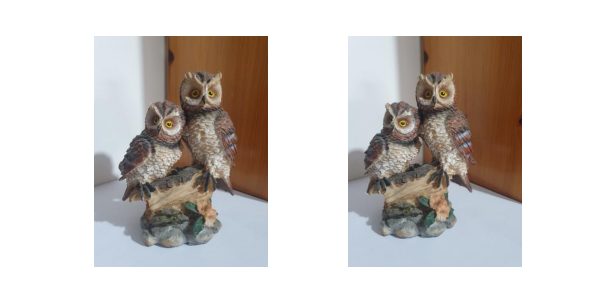

In [2]:
%matplotlib widget
    
# %matplotlib notebook
images = [
        cv2.imread(f'../images/owl/{i}.jpg', cv2.IMREAD_COLOR_RGB) for i in [11,22]
]

if any(elem is None for elem in images):
    raise ValueError("Could not load one of the images.")

fig, axes = plt.subplots(1, len(images), figsize=(3*len(images),3))
for ax, img in zip(axes, images):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

The main goal is to get a point cloud in 3D space of these owls. The following was created from just the first two pictures from the left:
![owls](../images/owl/owls.gif)

# 3D reconstruction

Looking on a 3D scene, we cannot really reconstruct it from a single image. Indeed, seeing an object in the picture, we can't really determine its distance from the camera: It can be a small object close by, or a large object far away. We only know the direction from the camera towards it, or in other words **it is on the line** starting from the camera, passing through the pixel in the image in which we see it, until it reaches the actual object.

However, if we can see the same object from two different positions, then suddenly it is on two lines in the 3D space, and any two such distinct lines intersect at at most a single point. Hence, if we have two images of the same object, from two different positions, and we know well enough how to match the pixels from the two images, we can reconstruct the 3D object (and this is one of the main reasons why we need two eyes to see the world...).

With this in mind, we can go over every pixel on the first image, and try to fit it to any pixel on the second image to find good matching. However, not only does this take a long time just to go over all the pair of pixel choices, but even comparing them given the choice is not trivial. What happens if we are zoomed in, or rotated in one image compared to the second? How can we compare the neighborhoods of these pixels?

The goal of this work is to describe one of the technique to make this process feasible. The main steps are:
1. Find some **good small matching** between the images (say 100 points).
2. Use this small matching to find some **geometric connection** between the images, which is called the **fundamental matrix**.
3. Use this matrix to **$y$-align** the images: the line of height $y$ of one image maps to the line of height $y$ in the second.
4. Once they are aligned, for each pixel we **only need to scan one line** (more or less...) for good matches.
5. Use the fundamental matrix to find the **relative position and orientation** of the second image compared to the first.
6. Finally, using the good matching from (4) and the relative position and orientation from (5) to **triangulage the 3D positions** of the pixels that we see.
7. Use some point cloud library to plot this points and **enjoy it**!

Let's start!

---
# 1. Comparing images

The first step in the process, is given two images, find "interesting" keypoints in each of them, and try to match between them. For example, using the SIFT algorithm we get the following:

<function matplotlib.pyplot.show(block=None)>

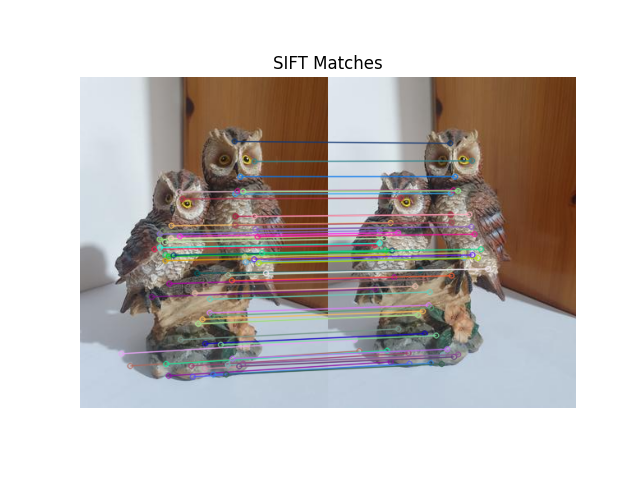

In [3]:
image_system = sift_compare.ImageSystem(images)

plt.figure()
plt.imshow(image_system.matching_image(from_index=0, to_index=1, threshold=0.45))
plt.title("SIFT Matches")
plt.axis('off')
plt.show

Note that these two pictures were taken from close, but not the same position and orientation. The closer the two positions (and orientations) are, the easier it is to matches between the images. However, we don't want the images to be taken from the same position, since we lose all the 3D input (though we can use it to create the **panoramic view** mentioned above).

As we want to actually use these matches, and not just plot them:

In [4]:
matching = image_system.matching(from_index=0, to_index=1, threshold = 0.45)

Unfortunately, we can't use the SIFT method by itself to match big chunks of the images, but we can in a way eventually expend this good small matching into a large one.

---
# 2. The fundamental matrix

The next step is to extract a **geometric connection** from the good matching that we have. This step appears both here in the **3D reconstruction** problem, and its simpler version of creating **panoramic view**. This connection is represented by a $3 \times 3$ matrix, and involves some interesting projective linear algebra which [I covered most of it here](points_of_view.md). 

In the **panoramic view**, the difference between the two images is just the **relative orientation**, and this matrix is this relative orientation, so we can simply apply it projectively to one image, and we are ready (almost) to glue it to the other. In the **3D reconstruction** problem this is just the first step, and we will need to somehow extract from it both the **relative position** and **relative orientation**. We will cross this bridge when we get to it, but before that, this matrix already has an interesting geometric property.

This matrix $F$ is called **the fundamental matrix** and it satisfies the following interesting geometric property. 

### The fundamental matrix property
>If there is any point in the 3D space, which can be seen in the first image at pixel $(x_1, y_1)$ and in the second image at pixel $(x_2, y_2)$, then these points satisfy:
>$$\pmatrix{x_1 & y_1 & 1} F \pmatrix{x_2 \\ y_2 \\ 1} = 0.$$

Using this property, and the matching from the previous section, we can find $F$:

In [5]:
original_fundamental = reconstruction3d.generate_fundamental(matching)

print(original_fundamental)

[[-1.14e-06  8.56e-05 -2.40e-02]
 [-8.24e-05  1.31e-06  1.45e-02]
 [ 2.43e-02 -1.90e-02  9.99e-01]]


To understand geometrically the property above, suppose that we have a given pixel $(x_1, y_1)$ in the first image and we want to find its match in the second. We can rewrite the property from above as:
$$ \begin{align}
(a,b,c) & := (x_1,y_1,1)\cdot F \\
0 & = a\cdot x_2 + b\cdot y_2 +c
\end{align} $$

In other words, the pixel position from the first image, defines a line parameterized by $(a,b,c)$ on the second image, and the corresponding pixel there must be on this line. These lines are called [**epipolar lines**](https://en.wikipedia.org/wiki/Epipolar_geometry) and the reason for their existence is quite interesting.

As mentioned before, we can't really determine a distance from an object by viewing it from a single point. It can be a small object close by, or a large object far away. We only know the direction from the camera towards it, or in other words **it is on the line** starting from the camera, passing through the pixel in the image in which we see it, until it reaches the actual object.

When viewing from another position we see this line, and need to determine on which point on the line it really is. The projection of this line in 3D space into the 2D line on the second image, is the line $ax+by+c=0$ we found above, which is the red line in the image below.

More specifically, $O_L$ sees $X$, but only as its projection $X_L$, so we don't really know where on the line it might be (e.g. $X_1, X_2, X_3,$ etc.). Knowing the $X_L$ position in the first image, we only know that $X$ is on some line, viewed on the second image seen from $O_R$. 

One more interesting details that we will need later on, is that these lines always pass through the first camera position $O_L$, so if we can see it in the second image (at point $e_R$), then the **epipolar line** must pass through it. In other words, all the **epipolar lines** pass through $e_R$, which we name the **epipole**.

![wiki epipolar geometry](../images/epipolar_geometry.png)

Let's view these epipolar lines in action:

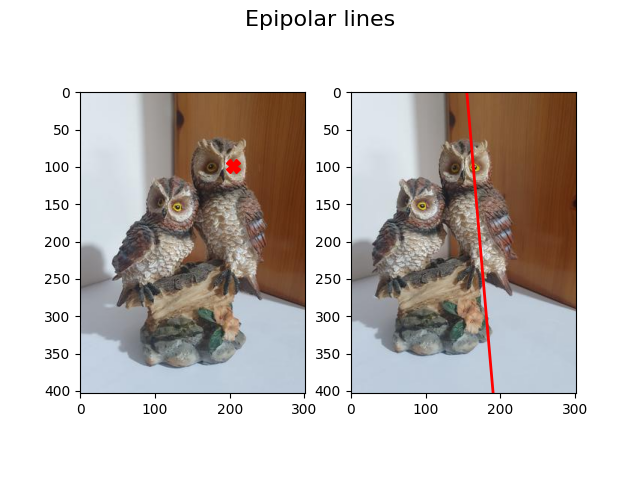

In [6]:
%matplotlib widget

plotter = reconstruction3d.EpipolarPlotter(images[0], images[1], original_fundamental)

epipolar_line_right = plotter.add_epipolar_line(left_image=False, with_point=True, color='red')
plotter.update_with_mouse(epipolar_line_right, mouse_click=True)
plotter.set_point(epipolar_line_right, 204, 99)

epipolar_line_left = plotter.add_epipolar_line(left_image=True, with_point=True, color='red')
plotter.update_with_mouse(epipolar_line_left, mouse_click=True)

plt.show()

As can be seen above, once we know the **fundamental matrix**, and look for the match of a **single pixel** on the left image, we only need to check the pixels along **one line** on the right image.

### Remark
> In an interactive non static version of this notebook, you can press the left image to choose other points and see their corresponding epipolar lines

---
# 3. Improving the fundamental matrix

When computing the fundamental matrix, there is all sorts of noise trying to prevent us from doing good job. Both the noise in the images themselves, but mainly from the matching that we found before. Not only do the matching from the left to the right image not necessarily point to the exact right pixel, but sometimes it matches a completely different pixel in the image.

We can measure how "good" the fundamental matrix with respect to the matching as follows. For each match $(x_1, y_1) \to (x_2, y_2)$ compute the line $(a,b,c) = (x_1, y_1, 1)F$ parameters as before, and measure the distance of $(x_2, y_2)$ from this line.

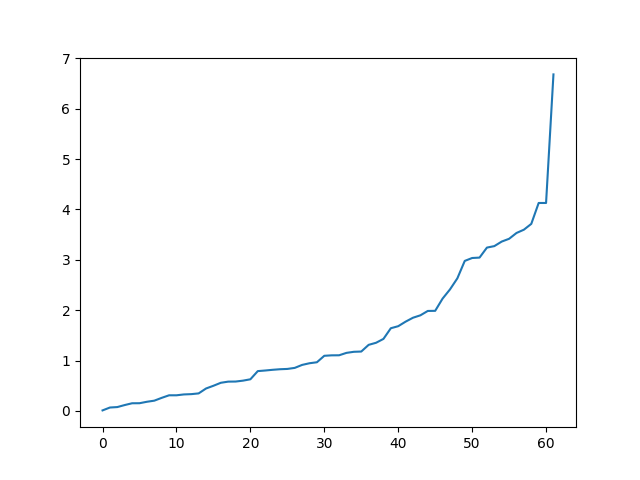

In [7]:
%matplotlib widget

original_distances = reconstruction3d.epipolar_distances(matching, original_fundamental)
plt.figure()
plt.plot(np.arange(len(original_distances)), sorted(original_distances))
plt.show()

As can be seen, about half of the matching is at most one pixel away from the corresponding epipolar line. If we are just one pixel away, we can just scan the epipolar line, and the two lines before and after it. However, if it is larger, even like 5 pixels away, we suddenly need to scan 11 lines which will take much longer.

For example, the best matching from above are the pair of points, and epipolar lines:

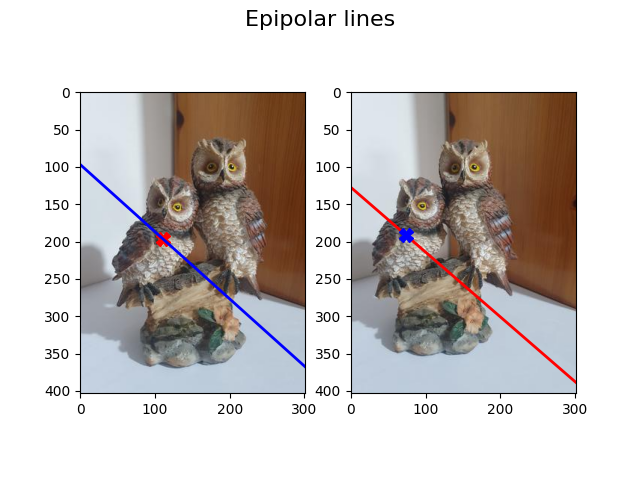

In [8]:
%matplotlib widget

index = np.argmin(original_distances)

importlib.reload(reconstruction3d)   

plotter = reconstruction3d.EpipolarPlotter(images[0], images[1], original_fundamental)
epipolar_line_right = plotter.add_epipolar_line(left_image=False, with_point=True, color='red')
epipolar_line_left = plotter.add_epipolar_line(left_image=True, with_point=True, color='blue')
plotter.set_point(epipolar_line_right, *matching[index][0])
plotter.set_point(epipolar_line_left,  *matching[index][1])
plt.show()

On the other hand, the worst match from above is:

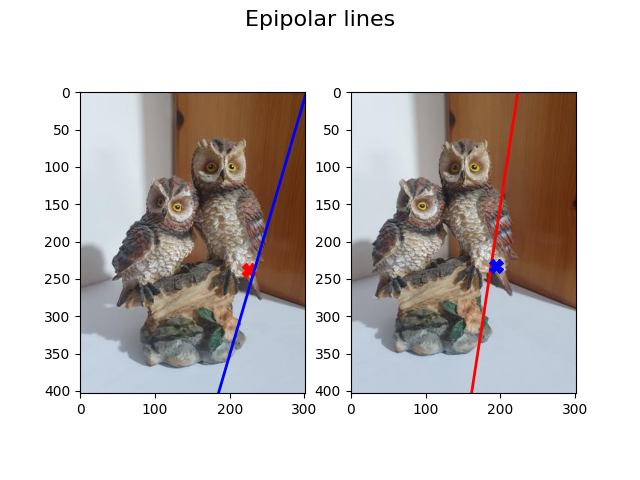

In [9]:
%matplotlib widget

index = np.argmax(original_distances)

plotter = reconstruction3d.EpipolarPlotter(images[0], images[1], original_fundamental)
epipolar_line_right = plotter.add_epipolar_line(left_image=False, with_point=True, color='red')
epipolar_line_left = plotter.add_epipolar_line(left_image=True, with_point=True, color='blue')
plotter.set_point(epipolar_line_right, *matching[index][0])
plotter.set_point(epipolar_line_left,  *matching[index][1])
plt.show()

There are two main reason why the pixel to epipolar lines don't match:
1. The matching itself might be wrong, or
2. The computation of the fundamental is wrong.

If all the matchings are "real" without any errors, the computation of the approximate fundamental matrix will give the actual fundamental matrix. However, whenever the matching is off, it affects the computation, which might cause even good matching pair to not fit the epipolar lines. One way to avoid such outliers, is to compute "many" fundamental matrices, and see which one of them is "best".

In my case, I used the "Least Median of Squares" approach:
1. Randomly choose a subset of the matching (specifically here 8 points),
2. Compute the distances between the matching point to the epipolar line,
3. Among these subsets, choose the one with the smallest median.

For example, if we know that $3/4$ of the matching pairs are really good, then the probability to choose just such good pairs in (1) is about $\left(\frac{3}{4}\right)^8~0.1$. Thus, on average it will take 10 tries to fall on such good choice.

I also added an extra simple step to remove outliers. Once for any choice of subsets the median distance is small, I remove all the matching with too large of a distance, by considering them as outliers.

Median of original fundamental matrix: 1.0998466289622129

Running Least Median of Squares:
Improved median to 12.056764305907244.
Improved median to 2.3019430637171676.
Improved median to 1.632760287578715.
Improved median to 1.198106743781066.
Improved median to 0.2905618577056603.
Improved median to 0.23423302570190302.
Improved median to 0.1809561027190698.

New fundamental matrix:
[[ 3.62e-06 -1.01e-04  2.64e-02]
 [ 1.49e-04 -3.86e-06  1.16e-01]
 [-3.63e-02 -1.25e-01  9.84e-01]]


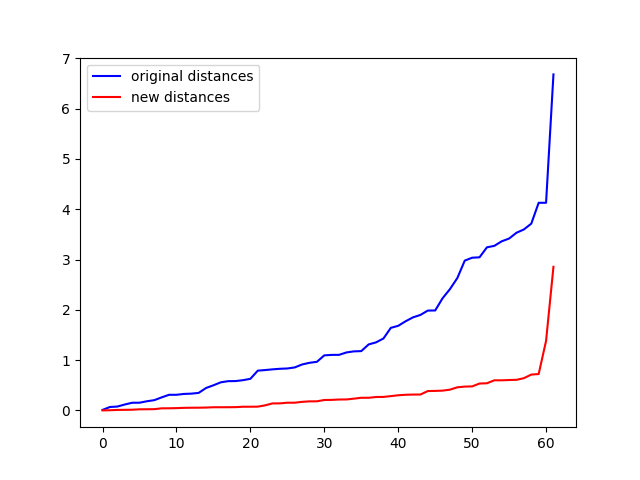

In [10]:
print(f'Median of original fundamental matrix: {np.median(original_distances)}')

print(f'\nRunning Least Median of Squares:')
importlib.reload(reconstruction3d)  
np.random.seed(0)
fundamental = reconstruction3d.least_median_fundamental(matching)

print('\nNew fundamental matrix:')
print(fundamental)

%matplotlib widget

distances = reconstruction3d.epipolar_distances(matching, fundamental)

plt.figure()

plt.plot(np.arange(len(distances)), sorted(original_distances), color='blue', label='original distances')
plt.plot(np.arange(len(distances)), sorted(distances), color='red', label='new distances')
plt.legend()
plt.show()


As can be seen, this new fundamental matrix have smaller median, namely more matching are "better", but also managed to improve all the distances, though in general we can get that the outliers become even more outliers. In any case, now the worst outlier is here:

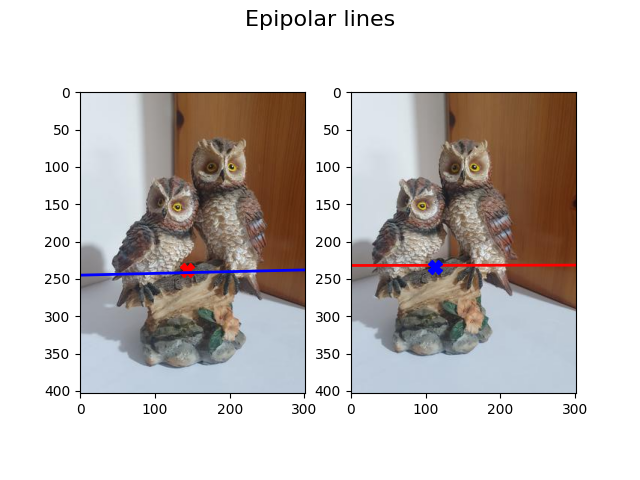

In [11]:
%matplotlib widget

index = np.argmax(distances)

plotter = reconstruction3d.EpipolarPlotter(images[0], images[1], fundamental)
epipolar_line_right = plotter.add_epipolar_line(left_image=False, with_point=True, color='red')
epipolar_line_left = plotter.add_epipolar_line(left_image=True, with_point=True, color='blue')
plotter.set_point(epipolar_line_right, *matching[index][0])
plotter.set_point(epipolar_line_left,  *matching[index][1])

plt.show()

Note that the camera moves slightly to the right from the left to the right image. This means that the background of the owls should move slightly to the right compared to the owls, and in particular the red mark on the left image. This is consistent more with the prediction of the epipolar line, than the original matching which is the blue mark.

---
# 4. Aligning the epipolar lines

We can already start with a pixel on the left image, find its epipolar line on the right, and scan the pixels on it for a good match. The problem with that approach is that we will try to compare a small neighborhood of the pixel on the left to small neighborhoods of pixels on the right, but are they the *same type* of neighborhoods? For example, if we start with a small axes aligned square on the left, do we end with a small axes aligned square on the right?

The answer is generally no. The square can be rotated, squashed, sheared, and go through all sort of other changes. To reduce some of these problem, we would like to change the images, so that epipolar lines on both the left and right image are **horizontal**. This means, that horizontal segements (e.g. the top and bottom edges of the square) will be mapped to horizontal segments.

What does this means algebraically? Recall that through the fundamental matrix we have that:
$$ \begin{align}
(a,b,c) & := (x_1,y_1,1)\cdot F \\
0 & = a\cdot x_2 + b\cdot y_2 +c
\end{align} $$

To get a horizontal line, means that $a=0$ so that the line is $y=-\frac{c}{b}$. Hence, we want:
$$0=a = (a,b,c)\pmatrix{1\\0\\0}=(x_1,y_1,1)\cdot F\pmatrix{1\\0\\0}.$$

This will be true for all choices of $x_1,y_1$ if and only if the first column of $F$ is zero:
$$F\pmatrix{1\\0\\0} = \pmatrix{0\\0\\0}.$$

### Question:
> Can we change the fundamental matrix, so that this new property will hold, anf if so how?

The main idea is that we can apply a projective transformation to our images, and this in turn will change the fundamental matrix. Intuitively, we should think about it as changing the orientation of the cameras with the relative position fixed (this is not exact, but close enough).

Mathematically speaking, given a $3\times 3$ invertible matrix $g\in \mathrm{GL}_3(\mathbb{R})$, we can apply it projectively to points in the second image, which is simply the matrix product
$$g\pmatrix{x_2\\y_2\\1}.$$

With these new coordinate, the fundamental matrix property becomes:
$$0 = \pmatrix{x_1 & y_1 & 1} F \pmatrix{x_2 \\ y_2 \\ 1} = \pmatrix{x_1 & y_1 & 1} \left(F\cdot g^{-1}\right) \left(g \pmatrix{x_2 \\ y_2 \\ 1}\right) .$$

In other words, we have a "new" fundamental matrix $F\cdot g^{-1}$. In the [mathematical background here](points_of_view.md) we see that the fundamental matrix has **rank 2**, so by basic linear algebra, we can find $g$ such that $Fg^{-1}$ has 0 in the first column. Actually, we can find infinitely many such matrices, so how do we choose? To find a good choice, we note that we don't want $g$ to distort the image too much so we use it as a guide line to construct $g$.

1. As a first simple step, we **translate the image so that its center moves to the origin** (or choose other point as the main point of interest). In the following steps we will try to keep the distortion at the origin as minimal as possible.
2. Next, we note that **all the epipolar lines pass through the epipole** (by definition). So we want to find $g$ that maps it to the "infinity" points in the projective geometry. Sounds weird and difficult, by when viewed using vectors in $\mathbb{R}^3$ this just means that if $v=(v_x,v_y,1)^T$ is the epipole, we want $g\cdot v$ to have zero in the $z$-coordinate. One simple way to do it is by a **$z$-shearing matrix** of the form:
   $$\pmatrix{1&0&0\\0&1&0\\s_x& s_y& 1}.$$
   Geometrically, is not that simple to understand what this shearing does to the 2D image, but algebraically, it is easy to check that if the epipole is not already at infinity, then we can use such matrix to move it there. Moreover, this operation **doesn't distort the origin** in the sense that the derivative there is the identity.
3. Once at infinity, **all the epipolar lines will be parallel**. Next we rotate the image so they will be horizontal and we are done.

### Remark:
> - If the epipole is inside the image, we have a problem, since we don't want to send parts of the image to infinity. While we can still work with it if we really wanted to, it will not be stable computationally. In other words, when creating pictures for 3D reconstruction, try to do it in a way where you don't see the other camera position in your picture. If you still see the camera in the image, then you can cut it down to smaller pieces, and remove the piece which contains the position of the camera.
> - Similarly, even if the epipole is outside the image, when you send it to infinity do it in a direction away from the image. For example, if the epipole is right of the image, you should send it more right to infinity, rather than up.

Let's see this step in action, where instead of $g$ we will use $H_1$ (since soon we will have a second transfortmation $H_0$ for `images[0]`).

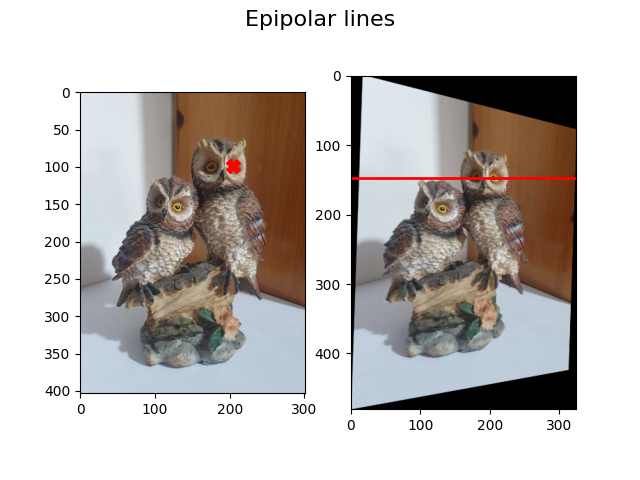

In [12]:
h1, w1 = images[1].shape[:2]
H1, fundamental1 = reconstruction3d.epipole_to_infinity(fundamental, w1, h1)

img1, domain1 = reconstruction3d.apply_proj(H1, images[1])

# After applying the projection, the image is not necessarily in the positive quadrant, where we plot it
H1 = reconstruction3d.translation_mat(-domain1.x, -domain1.y) @ H1
fundamental1 = fundamental1 @ reconstruction3d.translation_mat(domain1.x, domain1.y)

%matplotlib widget
importlib.reload(reconstruction3d)   

plotter = reconstruction3d.EpipolarPlotter(images[0], img1, fundamental1)
epipolar_line = plotter.add_epipolar_line(left_image=False, with_point=True, color='red')
plotter.set_point(epipolar_line, 204, 99)
plotter.update_with_mouse(epipolar_line, mouse_click=True)
plt.show()

Next we want to extend it so that the epipolar lines on the left image are also horizontal, but more over they are at the same height as the epipolar lines on the right image.

For the first condition, it is very similar to what happend before. Applying a maph $g$ to the coordinates of the first image, the fundamental matrix property is:

$$0 = \pmatrix{x_1 & y_1 & 1} F \pmatrix{x_2 \\ y_2 \\ 1} = \pmatrix{x_1 & y_1 & 1} g^T \left(g^{-T}\cdot F \right) \pmatrix{x_2 \\ y_2 \\ 1} .$$

If before we want the first column to be zero, now we will want the first row of $g^{-T}F$ to be zero (and note that if the first column of $F$ is zero, then the same holds for $g^{-T}F$). But, now we further want the lines to have the same height, namely the point $(x_1,y)$ should correspond to $(x_2,y)$ with the same $y$. Writing this down we get:
$$\pmatrix{x_1 & y & 1} \pmatrix{0 & 0 & 0 \\ 0 & F_{2,2} & F_{2,3} \\ 0 & F_{3,2} & F_{3,3}} \pmatrix{x_2 \\ y \\ 1} = 0,$$
or equivalently:
$$F_{2,2}\cdot y^2 + (F_{2,3}+F_{3,2})y + F_{3,3}=0,\;\forall y$$
The only way for this to hold, is if $F_{2,2}=F_{3,3}=0$ and $F_{2,3}=-F_{3,2}$, or in other words, up to some nonzero scalar, our matrix should be
$$g^{-T}F=\lambda \pmatrix{0&0&0\\0&0&1\\0&-1&0}.$$

Again, since $F$ has rank 2 and its first column is zero, then we know that there exists such $g$ invertible. The specific way which I used to find such a matrix is :
1. First do another $y$-translation of the right image, which on the fundamental matrix just adds the second column times some scalar to the third. By choosing the scalar in a smart way, the resulting two columns will be perpendicular to one another. Denote these columns by $v_2, v_3$ so that after this operation we have
     $$F=\pmatrix{|&|&|\\0&v_2&v_3\\|&|&|}$$  
2. Set $v_1 = v_2 \times v_3$ to complete the columns to an orthogonal basis.
3. Finally, choose
   $$g^{-T} = \pmatrix{-&v_1&-\\-&v_3/|v_3|^2&- \\ -&-v_2/|v_2|^2&-}.$$

Because of the orthogonality, we can compute $g$ easily by
$$g = \pmatrix{-&v_1&-\\-&v_3&- \\ -&v_2&-}.$$

Here too there are many more choices for $g$ which fits the conditions, and actually one choice is not enough in general. When viewing objects from different positions, the may stretch or contract according to their orientation with respect to the camera. Since we can't really control these orientations, we should run this run the algorithm several times with different such $g$'s. However, until I implement this feature, I will just choose one such choice and work with it.

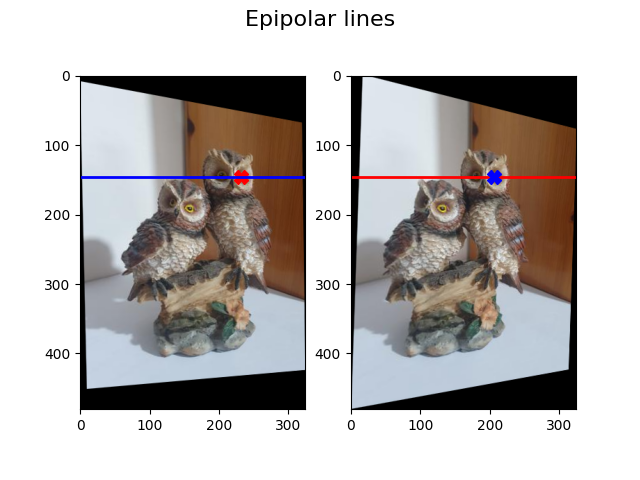

In [13]:
from vision.image_stitching import Rect
importlib.reload(reconstruction3d)  

H0, H1 = reconstruction3d.y_align_images(Rect.from_image(images[0]), Rect.from_image(images[1]), fundamental)

x_stretch = 9
x_shear = 0.27
x_distort = np.array([
        [x_stretch,x_shear,0],
        [0,1,0],
        [0,0,1]])

H0 = x_distort @ H0

# Move both the images to the same coordinate system, and to the positive quadrant
img0, H0, img1, H1 = reconstruction3d.combined_coordinates(images[0], H0, images[1], H1)

%matplotlib widget
importlib.reload(reconstruction3d)   

plotter = reconstruction3d.EpipolarPlotter(img0, img1, np.array([[0,0,0],[0,0,1],[0,-1,0]]))
epipolar_line_right = plotter.add_epipolar_line(left_image=False, with_point=True, color='red')
plotter.set_point(epipolar_line_right, 231, 146);
plotter.update_with_mouse(epipolar_line_right, mouse_click=True)
epipolar_line_left = plotter.add_epipolar_line(left_image=True, with_point=True, color='blue')
plotter.set_point(epipolar_line_left, 206, 146);
plotter.update_with_mouse(epipolar_line_left, mouse_click=True)
plt.show()

---
# 5. Scanning

We are now ready to start scanning the epipolar lines: 
1. We take a **grid of points** on the left image,
2. Convert them to points on the **aligned version** of the image,
3. For each such point:
    1. Generate a **square window** around the point
    2. For each point in the corresponding epipolar line on the right image generate another **square window**.
    3. Find the best match using some distance function (specifically in my case, the Euclidean norm).

For example:

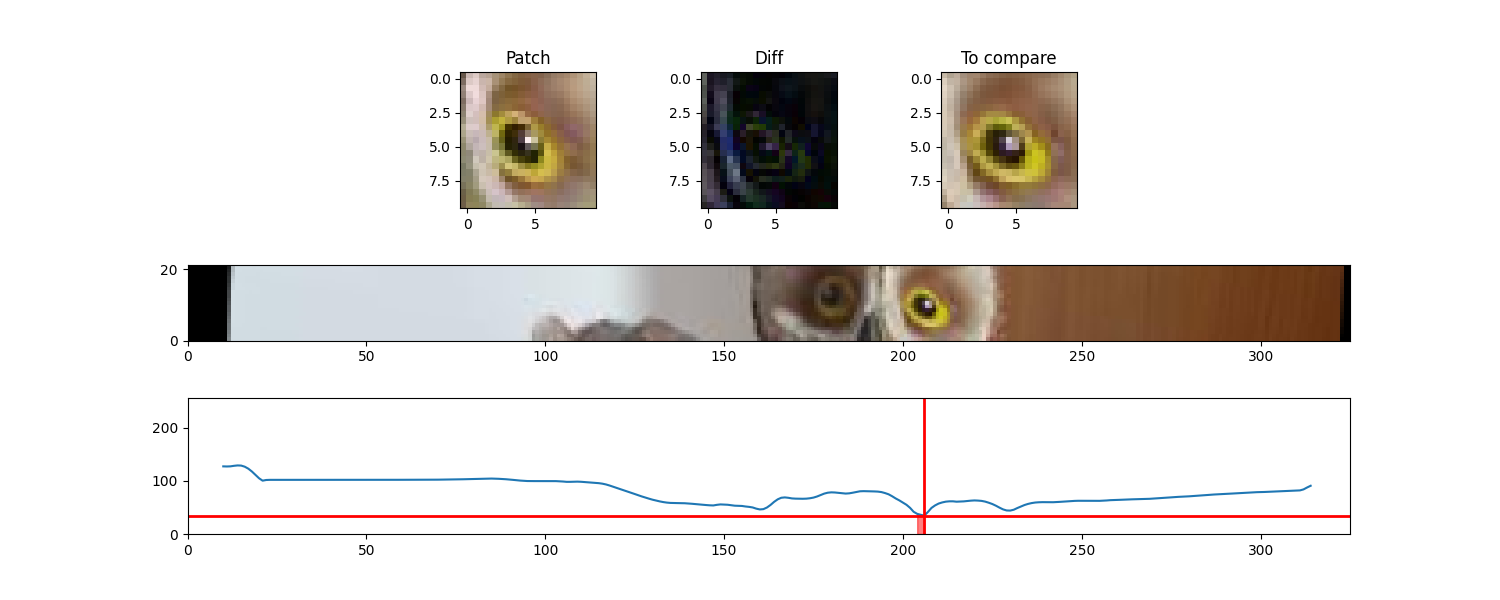

In [14]:
scan_visual = reconstruction3d.LineScanVisual()
radius = 10
y = 146
x = 231
scan_visual.set_data(radius = radius, patch=img0[y-radius: y+radius+1, x-radius: x+radius+1], strip=img1[y-radius: y+radius+1, :])

The top left picture is the fixed patch window from left window. The top right picture is a window of the same size around the same eye in the right image. In the middle we see the difference between these images. The closer they are, the more black we see in this difference. If you actually run this notebook, and not just view a static version of it, then you can point your mouse along the strip to compare with other places.

Finally, the graph on the bottom if the difference in norm between the corresponding window. As can be seen, the minimum value is attained on the actual eye of the owl. Going a bit to the left, the difference is still low, but outside it is (mostly) higher.

For each such line we look for this minimum point, and we say that it is a good match if:
1. The minimum value is low enough, and
2. Other values close to the minimum in height, are only attained near the actual minimum.

In other words, we look for **good localized** match. The first condition is of course obvious, and as for the second we want to avoid repeating patterns. For example, if we try to match a point on a white wall, it will probably have good matches with a lot of points (if the wall is consistently white). These are not good matches so we try to avoid them.

In [15]:
importlib.reload(reconstruction3d)    
grid_dist = 2
correspondence, bad_mask = reconstruction3d.find_correspondence(images[0], H0, images[1], H1, grid_dist=grid_dist, radius = 4)

Let's first view the points which we didn't manage to match, by coloring all the points that we did match in black:

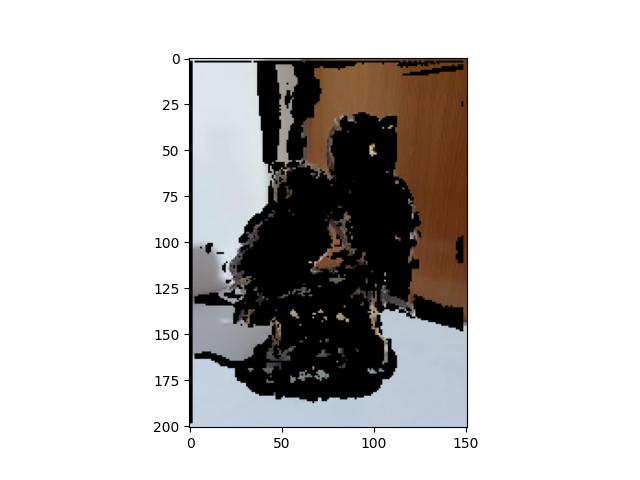

In [16]:
plt.figure()

h0, w0 = images[0].shape[:2]
plt.imshow(images[0][:(h0//grid_dist)*grid_dist:grid_dist,:(w0//grid_dist)*grid_dist:grid_dist] * bad_mask)
plt.show()

As can be seen, many pixels on the owls themselves were matched (hopefully succesfully). On the other hand, pixels on the floor and walls were mostly unmatched, not because there weren't good matched, but because there were too many of them, so we don't know what the right match is.

### Remark
> While the walls themselves are hard to match, the transition between them is much easier, even though the same type of transition appears in many places. Indeed, the reason is that now we only need to look for the transition on a single horizontal line, and if it appear only once there, then we can identify it well.

---
# 6. Relative position and orientation

We are almost ready to start reconstructing the 3D owls. However one crucial step we need to do before it is to actually find the relative position and orientation of the second camera with respect to the first. 

A similar problem arises in the **panoramic view** problem, but there the pictures are taken from the same position and only different orientations. Here the problem is much more involved since:
1. We need to find both the **relative orientation** and **relative position**, and
2. To do this we need to know the **calibration** of the camera.

When taking a picture, the camera can "distort" the image it self. Some of the distortion is very simple, just translation and maybe zoom in or out (which is **not the same** as moving forward and backwards with the camera!). Some can be more problematic, since maybe the camera makes the objects look taller or wider than they really are (namely scale at different rates along the $x$ and $y$ axis). There are also non linear distortion which usually happen near the edges of the image because of the structure of the lens. Ignoring this nonlinear distortion, the calibration matrix of the camera usually contains a scaling and translation step, which is easily represented as a $3 \times 3$ upper triangular matrix:
$$C = \pmatrix{sx&0&tx \\ 0&sy&ty \\ 0&0&1}.$$

Given this calibration matrix, the relative position $P$ and relative orientation, which in the 3D space is just a rotation $R$, all of these factor are joined together to form the fundamental matrix as:
$$F= C^{-T} \cdot [P]_\times \cdot R \cdot C^{-1},$$
where $P$ is the $3\times 3$ matrix representing the crossed product with the vector $P$, namely the anti-symmetric matrix
$$[P]_\times = \pmatrix{0&-P_3 & P_2 \\ P_3 & 0 & -P_1 \\ -P_2& P_1 & 0}.$$

The matrix $E=[P]_\times \cdot R$ is usually called **the essential matrix**, and if we manage to find it we can decompose it back, almost, to $P$ and $R$. Actually there are always 4 such decompositions but not all of them are equal. It turns out that once you try to actually triangulate good matches to find the position in 3D, then 3 out of the 4 decompositions, will produce points behind the camera. Taking the decomposition which gives all (or at least the most) points in front of both camera will be our choice. I covered the math behind this problem in general [here](points_of_view.md) and specifically the decomposition to anti-symmetric and orthogonal [here](skew_symmetric_orthogonal).

As for the calibration matrix, oddly enough, cameras don't like to specify these details. However, if you take a picture of a known object where you know exactly its position in space, then you can find the calibration matrix using some linear algebra. However, this means not only measuring distances, but also angle to a very high degree, and then finding all the right keypoints in a given image which is much more tedious than it should be.

Luckily for us, there is a more automatic way to do it using [chessboard detection](https://en.wikipedia.org/wiki/Chessboard_detection). So if you ever noticed that some people like to take pictures of empty chess boards from all sorts of angles, then this is probably the reason. So I went and took several picture of such a chess board (and note that it is not squared, but has $10 \times 7$ squares):

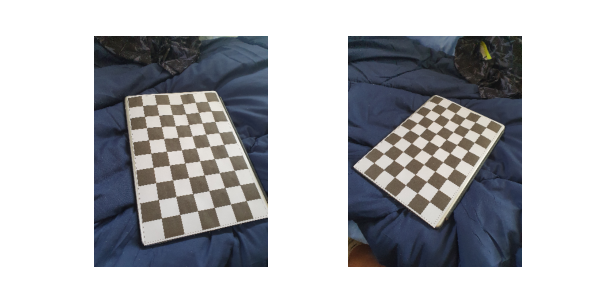

In [17]:
%matplotlib widget

chess_images = [
    cv2.resize(
        cv2.imread(f'../images/calibration/{i}.jpg', cv2.IMREAD_COLOR_RGB),
        dsize=(0,0), fx=0.1, fy=0.1)
    for i in [1,2,3,4,5,6]
]


fig, axes = plt.subplots(1, len(images), figsize=(3*len(images),3))
for ax, img in zip(axes, chess_images):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

I will use a premade OpenCV function to extract the matrix orientation:

In [18]:
importlib.reload(reconstruction3d)    

camera_matrix = reconstruction3d.calibrate_from_images(chess_images)

Camera matrix:
 [[324.13   0.   154.66]
 [  0.   323.84 189.67]
 [  0.     0.     1.  ]]
Distortion coefficients:
 [[ 0.3  -1.3  -0.02  0.    2.31]]


Finally, we can compute the relative position and orientation:

In [19]:
rel_position, rel_rotation = reconstruction3d.find_relative_position(fundamental, camera_matrix, matching)
rel_position /= np.linalg.norm(rel_position)

Counted 0/62 points in front of both cameras
Counted 0/62 points in front of both cameras
Counted 62/62 points in front of both cameras
Counted 0/62 points in front of both cameras


---
# 7. Triangulataion

Now we have all the information need to start doing the actuall 3D reconstruction. We have good pairs of matching from two positions, so we only need to traingulage the matching:

In [20]:
pixel_position, points, colors = reconstruction3d.compute_point_cloud(images[0], correspondence, camera_matrix, rel_rotation, rel_position)

Some of the point in the point cloud we created are probably in the wrong place. To fix it a little bit, I wrote a function that 
1. Remove all the points which somehow got behind the camera, and
2. Of the remaining point remove those which are too far from the center, or equivaelntly keep those in the 1-99 percentile.

In [21]:
good_points_mask = reconstruction3d.good_points_mask(points, 1, 99)

pixel_position = pixel_position[good_points_mask]
points = points[good_points_mask]
colors = colors[good_points_mask]

There are 12069/12127 points in front of the camera


Now we just need to send it to some point cloud plotter, and we are done:

In [22]:
%matplotlib widget
import pyvista as pv

pv.set_jupyter_backend('client')

importlib.reload(point_cloud)    

point_cloud.visualize_with_pyvista(points, colors/255)

mid_dist=np.float64(0.02666788959634128)


Widget(value='<iframe src="http://localhost:49651/index.html?ui=P_0x218d1123880_0&reconnect=auto" class="pyvis…

---
# What's next ?

There are a lot of optimizations and big fixing waiting to happen in the code base, but the next big step is to combine point clouds from different image pairing. This can be decomposed into two problems:

1. What if the images come from different cameras for which we don't know the camera calibration? Fortunately, if we start with a "known" 3D model (which we could extract from a camera with known calibration), then we can use it to calibrate the new images, even without access to the new camera.
2. The bigger problem is how to combine two points clouds together. This means removing outliers, combining nearby point, smoothing out close regions etc.

Once I know how to combine point clouds, I can take pictures from all around the object to create a more full 3D model. Then, we have an even more interesting step. The point cloud is nice, but not efficient as a model representation. I would like eventually to be able to convert the point cloud into a mesh which not only can look better (without so many holes) but can be used as actual physical object which can be used in games, videos etc.

But this point is a good place to stop, until I figure out how to continue.

---

**Ofir David**: [https://prove-me-wrong.com/](https://prove-me-wrong.com/)

**Contact**:	 [totallyRealField@gmail.com](mailto:totallyRealField@gmail.com)